# Lecture 4. CNN Build (VGG)

## 1. 환경 설정

In [1]:
# Colab에서는 pytorch 설치 필요
# !pip install torch torchvision

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import skimage
from skimage import transform as skit

print(torch.__version__)

2.0.0+cu117


In [3]:
# Pytorch GPU check (Colab에서는 실행시킬 필요 없음!)
import os, torch
print("현재 pytorch 버전은 무엇인가? : %s" %(torch.__version__))
print("사용 가능한 GPU가 존재하는가? (True or False): ", torch.cuda.is_available())
if torch.cuda.is_available():
    print("사용 가능한 GPU의 수는 {} 개 입니다.".format(torch.cuda.device_count()))
    print("GPU 각각의 이름은 아래와 같습니다.")
    for i in range(torch.cuda.device_count()):
        print("GPU {}: {}".format(i, torch.cuda.get_device_name(i)))
else:
    print("사용 가능한 GPU가 존재하지 않습니다. 혹은 GPU를 Pytorch가 찾지 못하고 있습니다.")

현재 pytorch 버전은 무엇인가? : 2.0.0+cu117
사용 가능한 GPU가 존재하는가? (True or False):  True
사용 가능한 GPU의 수는 4 개 입니다.
GPU 각각의 이름은 아래와 같습니다.
GPU 0: NVIDIA GeForce GTX TITAN X
GPU 1: NVIDIA GeForce GTX TITAN X
GPU 2: NVIDIA GeForce GTX TITAN X
GPU 3: NVIDIA GeForce GTX TITAN X


## 2. Data 불러오기 및 전처리

In [101]:
data_path = '/home/student/Datasets/jhjeong/Test/' # 자신의 환경에 맞게 설정!

mnist_train = dset.MNIST(root=data_path, train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST(root=data_path, train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

* Data pre-processing
    - Image Resize: (1, 28, 28) -> (1, 64, 64)
    - One hot convert: 5 -> [0,0,0,0,0,1,0,0,0,0]

In [102]:
train_data, test_data = [], []
data_limit = [1000, 200] # train, val data limit
# Train data pre-processing
for i in range(data_limit[0]):
    data_x = skit.resize(mnist_train[i][0].numpy(), (1,64,64))
    data_y = [0] * 10
    data_y[mnist_train[i][1]] = 1
    train_data.append([data_x, np.array(data_y)])
print(len(train_data), len(train_data[0]))
# Test data pre-processing
for i in range(data_limit[1]):
    data_x = skit.resize(mnist_test[i][0].numpy(), (1,64,64))
    data_y = [0] * 10
    data_y[mnist_test[i][1]] = 1
    test_data.append([data_x, np.array(data_y)])
print(len(test_data), len(test_data[0]))

1000 2
200 2


(1, 64, 64)
5 [0 0 0 0 0 1 0 0 0 0]


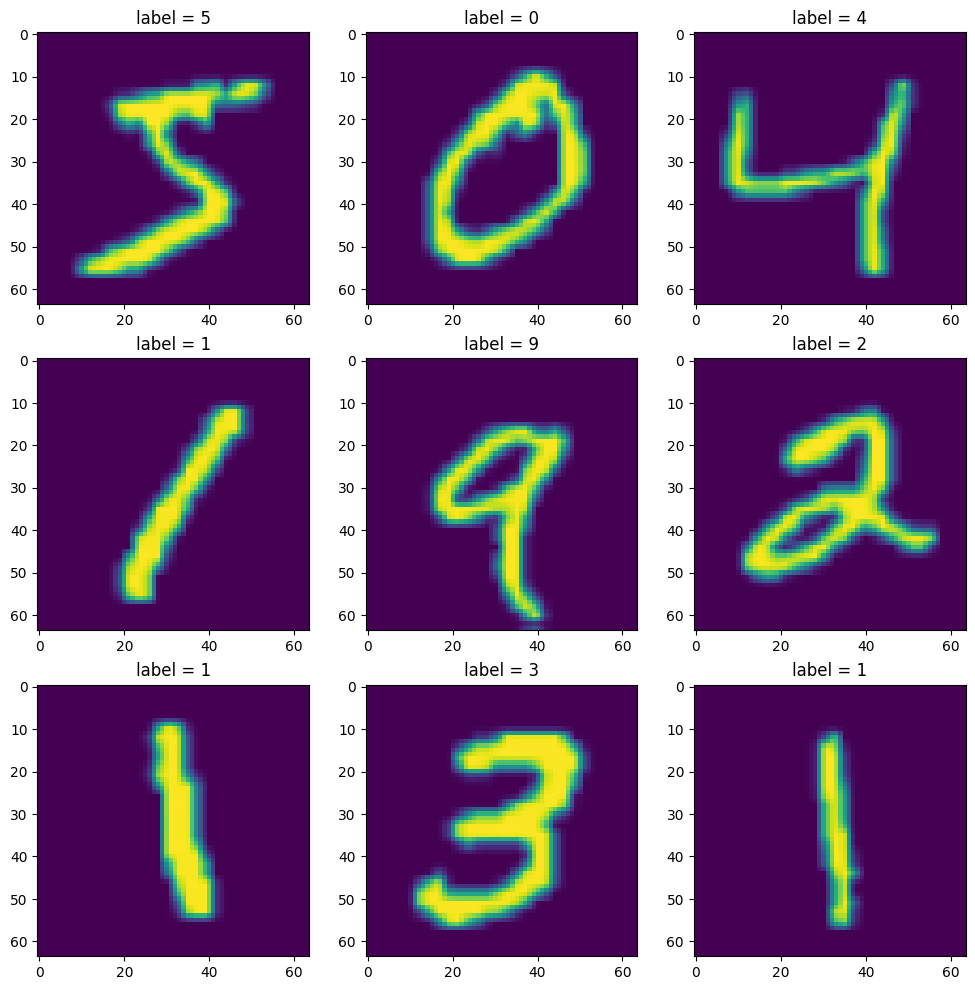

In [103]:
print(train_data[0][0].shape) # 0번째 프레임의 이미지 크기 출력
print(mnist_train[0][1], train_data[0][1]) # 0번째 프레임의 레이블(정답) 출력
plt.figure(figsize=(12,12))
for i in range(3*3): # 9개의 데이터 추가 확인
    plt.subplot(3,3,i+1)
    plt.imshow(np.moveaxis(train_data[i][0], 0, -1)) # np.moveaxis()는 channel 위치를 0 -> -1로 옮겨준다.
    plt.title(f'label = {mnist_train[i][1]}')

In [104]:
batch_size = 50

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2,drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2,drop_last=True)
print(len(train_loader), len(test_loader))

20 4


## 3. 모델 만들기

In [105]:
# 컨볼루션 연산이 2번 연속하는 경우
# 컨볼루션-활성화함수-컨볼루션-활성화함수-풀링
def conv_2_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

  
# 컨볼루션 연산이 3번 연속하는 경우
# 컨볼루션-활성화함수-컨볼루션-활성화함수-컨볼루션-활성화함수-풀링
def conv_3_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

In [106]:
# 위에서 정의한 블록들을 이용해 VGG 네트워크를 만들어보겠습니다.
# 필터의 개수가 2의 n승의 값을 가지기 때문에 base_dim이란 변수를 추가해서 단순화 했습니다.
# 현재 dog, cat 두 가지 클래스를 구분하려고 하기 때문에 num_classes=2로 설정했습니다.

class VGG16(nn.Module):
    def __init__(self, base_dim, num_classes=2):
        super(VGG16, self).__init__()
        self.feature = nn.Sequential(
            self.conv_2_block(1, base_dim),
            self.conv_2_block(base_dim, 2*base_dim),
            self.conv_3_block(2*base_dim, 4*base_dim),
            self.conv_3_block(4*base_dim, 8*base_dim),
            self.conv_3_block(8*base_dim, 8*base_dim),         
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(8*base_dim * 2 * 2, 100),
            nn.ReLU(True),                                                      # True 는 inplace 연산을 하겠다는 의미를 가집니다. inplace 연산은 결과값을 새로운 변수에 값을 저장하는 대신 기존의 데이터를 대체하는것을 의미합니다.
            #nn.Dropout(),
            nn.Linear(100, 20),
            nn.ReLU(True),
            #nn.Dropout(),
            nn.Linear(20, num_classes),
        )

    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)                                               # x.size(0)를 batch size로 바꿔도 같은 값입니다.
        x = self.fc_layer(x)
        return x
    
    def conv_2_block(self, in_dim,out_dim):
        model = nn.Sequential(
            nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        return model

  
    # 컨볼루션 연산이 3번 연속하는 경우
    # 컨볼루션-활성화함수-컨볼루션-활성화함수-컨볼루션-활성화함수-풀링
    def conv_3_block(self, in_dim,out_dim):
        model = nn.Sequential(
            nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        return model
    


In [108]:
# gpu가 사용 가능한 경우에는 device를 gpu로 설정하고 불가능하면 cpu로 설정합니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 모델을 지정한 장치로 올립니다.
model = VGG16(8, num_classes=10).to(device)

# 손실함수로는 크로스엔트로피를 사용합니다.
loss_func = nn.CrossEntropyLoss()

# 최적화함수로는 Adam을 사용합니다.
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print('model architecture = ', model)

cuda:0
model architecture =  VGG16(
  (feature): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): MaxPool2d(kernel_size

## 4. 모델 학습

In [109]:
for i, (x,y) in enumerate(test_loader):
    if i == 0:
        tx = torch.tensor(data=x, dtype=torch.float32, device=device, requires_grad=True)
        ty = torch.tensor(data=y, dtype=torch.float32, device=device, requires_grad=True)
        pred = model(tx)
        loss = loss_func(pred, ty)
        print(x.shape, y.shape, pred.shape, loss.shape)
        print()

        
        

torch.Size([50, 1, 64, 64]) torch.Size([50, 10]) torch.Size([50, 10]) torch.Size([])



/tmp/ipykernel_76252/44265658.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tx = torch.tensor(data=x, dtype=torch.float32, device=device, requires_grad=True)
/tmp/ipykernel_76252/44265658.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ty = torch.tensor(data=y, dtype=torch.float32, device=device, requires_grad=True)


In [110]:
# 학습 모듈
def train(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    pbar = tqdm(total=num_batches)
    train_loss, train_acc = 0, 0
    for batch, (x, y) in enumerate(dataloader):
        tx = torch.tensor(data=x, dtype=torch.float32, device=device, requires_grad=True)
        ty = torch.tensor(data=y, dtype=torch.float32, device=device, requires_grad=True)

        # Compute prediction error
        pred = model(tx)
        loss = loss_fn(pred, ty)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metric
        correct = (pred.argmax(1) == ty.argmax(1)).type(torch.float).sum().item()

        # Epoch result 
        train_loss += loss.item()
        train_acc += correct

        # Traing Process check
        loss, current = loss.item(), (batch + 1) * len(tx)
        acc = correct/len(tx)
        pbar.set_description(f" - Batch Training[{epoch}]({current}/{size}): loss = {loss:>5f}, acc = {100*acc:>0.1f}%")
        pbar.update(1)
    pbar.close()
    # epoch 
    train_loss /= num_batches
    train_acc /= size
    return train_loss, train_acc

In [111]:
# 검증 모듈
def test(dataloader, model, loss_fn, epoch, show=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            tx = torch.tensor(data=x, dtype=torch.float32, device=device, requires_grad=False)
            ty = torch.tensor(data=y, dtype=torch.float32, device=device, requires_grad=False)
            pred = model(tx)
            test_loss += loss_fn(pred, ty).item()
            test_acc += (pred.argmax(1) == ty.argmax(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    test_acc /= size
    if show:
        print(f"    = Validation[{epoch}]: val_loss = {test_loss:>5f}, val_acc: {(100*test_acc):>0.1f}%")
    return test_loss, test_acc

In [112]:
num_epoch = 100

history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}
for t in range(num_epoch):
    train_loss, train_acc = train(train_loader, model, loss_func, optimizer, t+1)
    val_loss, val_acc = test(test_loader, model, loss_func, t+1)
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    print(f'# Training[{t+1}/{num_epoch}]: loss = {train_loss:>5f}, acc = {100*train_acc:>0.1f}, val_loss = {val_loss:5>f}, val_acc = {100*val_acc:>0.1f}')

  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_76252/508833009.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tx = torch.tensor(data=x, dtype=torch.float32, device=device, requires_grad=True)
/tmp/ipykernel_76252/508833009.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ty = torch.tensor(data=y, dtype=torch.float32, device=device, requires_grad=True)
 - Batch Training[1](1000/1000): loss = 2.340374, acc = 12.0%: 100%|██████████| 20/20 [00:00<00:00, 43.69it/s]


# Training[1/100]: loss = 2.316789, acc = 9.9, val_loss = 2.334784, val_acc = 8.0


 - Batch Training[2](1000/1000): loss = 2.319581, acc = 12.0%: 100%|██████████| 20/20 [00:00<00:00, 44.60it/s]


# Training[2/100]: loss = 2.316089, acc = 9.9, val_loss = 2.333425, val_acc = 8.0


 - Batch Training[3](1000/1000): loss = 2.300502, acc = 12.0%: 100%|██████████| 20/20 [00:00<00:00, 51.38it/s]


# Training[3/100]: loss = 2.315294, acc = 9.9, val_loss = 2.331245, val_acc = 8.0


 - Batch Training[4](1000/1000): loss = 2.308642, acc = 12.0%: 100%|██████████| 20/20 [00:00<00:00, 51.45it/s]


# Training[4/100]: loss = 2.312981, acc = 10.1, val_loss = 2.312812, val_acc = 10.0


 - Batch Training[5](1000/1000): loss = 2.286305, acc = 14.0%: 100%|██████████| 20/20 [00:00<00:00, 57.32it/s]


# Training[5/100]: loss = 2.308548, acc = 9.2, val_loss = 2.305796, val_acc = 10.0


 - Batch Training[6](1000/1000): loss = 2.308650, acc = 10.0%: 100%|██████████| 20/20 [00:00<00:00, 52.99it/s]


# Training[6/100]: loss = 2.307533, acc = 9.2, val_loss = 2.304713, val_acc = 10.0


 - Batch Training[7](1000/1000): loss = 2.307886, acc = 8.0%: 100%|██████████| 20/20 [00:00<00:00, 44.15it/s]


# Training[7/100]: loss = 2.307213, acc = 9.2, val_loss = 2.296083, val_acc = 10.0


 - Batch Training[8](1000/1000): loss = 2.296728, acc = 12.0%: 100%|██████████| 20/20 [00:00<00:00, 43.21it/s]


# Training[8/100]: loss = 2.305161, acc = 9.2, val_loss = 2.301539, val_acc = 10.0


 - Batch Training[9](1000/1000): loss = 2.309309, acc = 12.0%: 100%|██████████| 20/20 [00:00<00:00, 51.48it/s]


# Training[9/100]: loss = 2.305448, acc = 10.3, val_loss = 2.294001, val_acc = 10.0


 - Batch Training[10](1000/1000): loss = 2.287089, acc = 8.0%: 100%|██████████| 20/20 [00:00<00:00, 46.15it/s]


# Training[10/100]: loss = 2.303907, acc = 9.2, val_loss = 2.298662, val_acc = 10.0


 - Batch Training[11](1000/1000): loss = 2.302646, acc = 8.0%: 100%|██████████| 20/20 [00:00<00:00, 45.68it/s]


# Training[11/100]: loss = 2.303769, acc = 9.2, val_loss = 2.294049, val_acc = 10.0


 - Batch Training[12](1000/1000): loss = 2.310449, acc = 12.0%: 100%|██████████| 20/20 [00:00<00:00, 51.25it/s]


# Training[12/100]: loss = 2.303683, acc = 10.7, val_loss = 2.293780, val_acc = 12.0


 - Batch Training[13](1000/1000): loss = 2.294593, acc = 16.0%: 100%|██████████| 20/20 [00:00<00:00, 48.39it/s]


# Training[13/100]: loss = 2.303124, acc = 11.7, val_loss = 2.294397, val_acc = 12.0


 - Batch Training[14](1000/1000): loss = 2.322866, acc = 10.0%: 100%|██████████| 20/20 [00:00<00:00, 50.37it/s]


# Training[14/100]: loss = 2.301859, acc = 11.7, val_loss = 2.290571, val_acc = 12.0


 - Batch Training[15](1000/1000): loss = 2.304603, acc = 14.0%: 100%|██████████| 20/20 [00:00<00:00, 51.63it/s]


# Training[15/100]: loss = 2.301797, acc = 11.7, val_loss = 2.293788, val_acc = 12.0


 - Batch Training[16](1000/1000): loss = 2.294984, acc = 14.0%: 100%|██████████| 20/20 [00:00<00:00, 47.94it/s]


# Training[16/100]: loss = 2.299429, acc = 11.7, val_loss = 2.280555, val_acc = 12.0


 - Batch Training[17](1000/1000): loss = 2.286180, acc = 14.0%: 100%|██████████| 20/20 [00:00<00:00, 41.13it/s]


# Training[17/100]: loss = 2.296348, acc = 12.9, val_loss = 2.267483, val_acc = 15.5


 - Batch Training[18](1000/1000): loss = 2.283891, acc = 16.0%: 100%|██████████| 20/20 [00:00<00:00, 40.07it/s]


# Training[18/100]: loss = 2.288641, acc = 14.3, val_loss = 2.246056, val_acc = 14.0


 - Batch Training[19](1000/1000): loss = 2.282204, acc = 12.0%: 100%|██████████| 20/20 [00:00<00:00, 46.22it/s]


# Training[19/100]: loss = 2.264578, acc = 12.1, val_loss = 2.181579, val_acc = 16.0


 - Batch Training[20](1000/1000): loss = 2.168512, acc = 22.0%: 100%|██████████| 20/20 [00:00<00:00, 49.11it/s]


# Training[20/100]: loss = 2.218230, acc = 15.5, val_loss = 2.103011, val_acc = 21.0


 - Batch Training[21](1000/1000): loss = 2.040184, acc = 20.0%: 100%|██████████| 20/20 [00:00<00:00, 49.10it/s]


# Training[21/100]: loss = 2.163243, acc = 17.5, val_loss = 2.061494, val_acc = 20.0


 - Batch Training[22](1000/1000): loss = 2.213151, acc = 14.0%: 100%|██████████| 20/20 [00:00<00:00, 41.05it/s]


# Training[22/100]: loss = 2.115764, acc = 20.3, val_loss = 2.030581, val_acc = 21.5


 - Batch Training[23](1000/1000): loss = 2.120276, acc = 22.0%: 100%|██████████| 20/20 [00:00<00:00, 45.22it/s]


# Training[23/100]: loss = 2.083984, acc = 21.0, val_loss = 2.060453, val_acc = 24.0


 - Batch Training[24](1000/1000): loss = 2.154355, acc = 30.0%: 100%|██████████| 20/20 [00:00<00:00, 45.33it/s]


# Training[24/100]: loss = 2.086116, acc = 23.5, val_loss = 1.949140, val_acc = 24.5


 - Batch Training[25](1000/1000): loss = 2.093730, acc = 24.0%: 100%|██████████| 20/20 [00:00<00:00, 54.54it/s]


# Training[25/100]: loss = 1.992575, acc = 27.6, val_loss = 1.910244, val_acc = 32.5


 - Batch Training[26](1000/1000): loss = 1.911967, acc = 24.0%: 100%|██████████| 20/20 [00:00<00:00, 47.23it/s]


# Training[26/100]: loss = 1.914912, acc = 30.1, val_loss = 1.854480, val_acc = 30.5


 - Batch Training[27](1000/1000): loss = 1.626369, acc = 34.0%: 100%|██████████| 20/20 [00:00<00:00, 52.92it/s]


# Training[27/100]: loss = 1.826427, acc = 32.5, val_loss = 1.737434, val_acc = 33.5


 - Batch Training[28](1000/1000): loss = 1.699798, acc = 32.0%: 100%|██████████| 20/20 [00:00<00:00, 57.77it/s]


# Training[28/100]: loss = 1.718988, acc = 36.0, val_loss = 1.647871, val_acc = 38.5


 - Batch Training[29](1000/1000): loss = 1.831400, acc = 30.0%: 100%|██████████| 20/20 [00:00<00:00, 56.39it/s]


# Training[29/100]: loss = 1.606531, acc = 40.9, val_loss = 1.523238, val_acc = 39.0


 - Batch Training[30](1000/1000): loss = 1.646308, acc = 48.0%: 100%|██████████| 20/20 [00:00<00:00, 50.27it/s]


# Training[30/100]: loss = 1.503371, acc = 47.8, val_loss = 1.557856, val_acc = 42.0


 - Batch Training[31](1000/1000): loss = 1.469579, acc = 48.0%: 100%|██████████| 20/20 [00:00<00:00, 50.78it/s]


# Training[31/100]: loss = 1.461048, acc = 50.2, val_loss = 1.412557, val_acc = 46.5


 - Batch Training[32](1000/1000): loss = 1.197758, acc = 56.0%: 100%|██████████| 20/20 [00:00<00:00, 53.60it/s]


# Training[32/100]: loss = 1.388736, acc = 52.1, val_loss = 1.406528, val_acc = 46.0


 - Batch Training[33](1000/1000): loss = 1.350452, acc = 60.0%: 100%|██████████| 20/20 [00:00<00:00, 55.09it/s]


# Training[33/100]: loss = 1.299757, acc = 54.6, val_loss = 1.352363, val_acc = 53.0


 - Batch Training[34](1000/1000): loss = 0.927832, acc = 72.0%: 100%|██████████| 20/20 [00:00<00:00, 47.14it/s]


# Training[34/100]: loss = 1.220504, acc = 59.0, val_loss = 1.328846, val_acc = 51.0


 - Batch Training[35](1000/1000): loss = 1.067989, acc = 64.0%: 100%|██████████| 20/20 [00:00<00:00, 48.27it/s]


# Training[35/100]: loss = 1.195110, acc = 59.5, val_loss = 1.287975, val_acc = 52.5


 - Batch Training[36](1000/1000): loss = 1.034150, acc = 62.0%: 100%|██████████| 20/20 [00:00<00:00, 41.18it/s]


# Training[36/100]: loss = 1.132090, acc = 62.7, val_loss = 1.183328, val_acc = 58.5


 - Batch Training[37](1000/1000): loss = 1.130163, acc = 52.0%: 100%|██████████| 20/20 [00:00<00:00, 50.50it/s]


# Training[37/100]: loss = 1.114401, acc = 63.2, val_loss = 1.195985, val_acc = 56.5


 - Batch Training[38](1000/1000): loss = 0.921463, acc = 68.0%: 100%|██████████| 20/20 [00:00<00:00, 55.94it/s]


# Training[38/100]: loss = 1.054798, acc = 64.6, val_loss = 1.164364, val_acc = 57.5


 - Batch Training[39](1000/1000): loss = 1.177298, acc = 56.0%: 100%|██████████| 20/20 [00:00<00:00, 52.65it/s]


# Training[39/100]: loss = 1.031689, acc = 65.9, val_loss = 1.117654, val_acc = 58.5


 - Batch Training[40](1000/1000): loss = 0.778232, acc = 72.0%: 100%|██████████| 20/20 [00:00<00:00, 47.93it/s]


# Training[40/100]: loss = 1.010250, acc = 67.2, val_loss = 1.126453, val_acc = 57.5


 - Batch Training[41](1000/1000): loss = 1.027330, acc = 54.0%: 100%|██████████| 20/20 [00:00<00:00, 53.14it/s]


# Training[41/100]: loss = 0.967105, acc = 67.5, val_loss = 1.060656, val_acc = 61.0


 - Batch Training[42](1000/1000): loss = 1.380483, acc = 50.0%: 100%|██████████| 20/20 [00:00<00:00, 52.31it/s]


# Training[42/100]: loss = 0.944196, acc = 69.0, val_loss = 1.076277, val_acc = 60.5


 - Batch Training[43](1000/1000): loss = 0.913271, acc = 72.0%: 100%|██████████| 20/20 [00:00<00:00, 46.33it/s]


# Training[43/100]: loss = 0.910744, acc = 70.4, val_loss = 1.017039, val_acc = 62.5


 - Batch Training[44](1000/1000): loss = 0.998601, acc = 76.0%: 100%|██████████| 20/20 [00:00<00:00, 54.49it/s]


# Training[44/100]: loss = 0.893459, acc = 71.0, val_loss = 0.966656, val_acc = 63.0


 - Batch Training[45](1000/1000): loss = 0.698663, acc = 76.0%: 100%|██████████| 20/20 [00:00<00:00, 48.70it/s]


# Training[45/100]: loss = 0.859372, acc = 72.3, val_loss = 0.977121, val_acc = 61.0


 - Batch Training[46](1000/1000): loss = 1.029382, acc = 70.0%: 100%|██████████| 20/20 [00:00<00:00, 49.91it/s]


# Training[46/100]: loss = 0.864083, acc = 71.8, val_loss = 0.929364, val_acc = 66.0


 - Batch Training[47](1000/1000): loss = 1.060273, acc = 74.0%: 100%|██████████| 20/20 [00:00<00:00, 50.44it/s]


# Training[47/100]: loss = 0.814054, acc = 73.8, val_loss = 0.995069, val_acc = 65.0


 - Batch Training[48](1000/1000): loss = 0.431979, acc = 90.0%: 100%|██████████| 20/20 [00:00<00:00, 51.79it/s]


# Training[48/100]: loss = 0.771399, acc = 75.2, val_loss = 0.873035, val_acc = 68.0


 - Batch Training[49](1000/1000): loss = 0.747283, acc = 74.0%: 100%|██████████| 20/20 [00:00<00:00, 53.80it/s]


# Training[49/100]: loss = 0.735590, acc = 74.9, val_loss = 0.839927, val_acc = 69.0


 - Batch Training[50](1000/1000): loss = 0.545604, acc = 82.0%: 100%|██████████| 20/20 [00:00<00:00, 46.78it/s]


# Training[50/100]: loss = 0.697761, acc = 77.5, val_loss = 0.809761, val_acc = 71.5


 - Batch Training[51](1000/1000): loss = 0.723531, acc = 74.0%: 100%|██████████| 20/20 [00:00<00:00, 49.78it/s]


# Training[51/100]: loss = 0.684024, acc = 77.4, val_loss = 0.774554, val_acc = 71.0


 - Batch Training[52](1000/1000): loss = 0.611570, acc = 74.0%: 100%|██████████| 20/20 [00:00<00:00, 50.58it/s]


# Training[52/100]: loss = 0.650885, acc = 79.2, val_loss = 0.737938, val_acc = 71.5


 - Batch Training[53](1000/1000): loss = 0.478982, acc = 86.0%: 100%|██████████| 20/20 [00:00<00:00, 49.21it/s]


# Training[53/100]: loss = 0.622785, acc = 79.3, val_loss = 0.708360, val_acc = 74.0


 - Batch Training[54](1000/1000): loss = 0.694226, acc = 82.0%: 100%|██████████| 20/20 [00:00<00:00, 50.91it/s]


# Training[54/100]: loss = 0.619216, acc = 80.0, val_loss = 0.746552, val_acc = 72.0


 - Batch Training[55](1000/1000): loss = 0.655266, acc = 74.0%: 100%|██████████| 20/20 [00:00<00:00, 54.49it/s]


# Training[55/100]: loss = 0.593274, acc = 79.2, val_loss = 0.702808, val_acc = 73.5


 - Batch Training[56](1000/1000): loss = 0.839046, acc = 82.0%: 100%|██████████| 20/20 [00:00<00:00, 48.42it/s]


# Training[56/100]: loss = 0.560179, acc = 82.2, val_loss = 0.664876, val_acc = 75.5


 - Batch Training[57](1000/1000): loss = 0.629558, acc = 88.0%: 100%|██████████| 20/20 [00:00<00:00, 49.37it/s]


# Training[57/100]: loss = 0.530635, acc = 83.4, val_loss = 0.654721, val_acc = 76.5


 - Batch Training[58](1000/1000): loss = 0.608903, acc = 82.0%: 100%|██████████| 20/20 [00:00<00:00, 39.52it/s]


# Training[58/100]: loss = 0.510142, acc = 82.5, val_loss = 0.573540, val_acc = 78.0


 - Batch Training[59](1000/1000): loss = 0.600195, acc = 80.0%: 100%|██████████| 20/20 [00:00<00:00, 47.65it/s]


# Training[59/100]: loss = 0.482116, acc = 84.3, val_loss = 0.579090, val_acc = 77.5


 - Batch Training[60](1000/1000): loss = 0.626989, acc = 78.0%: 100%|██████████| 20/20 [00:00<00:00, 41.83it/s]


# Training[60/100]: loss = 0.453482, acc = 85.5, val_loss = 0.581254, val_acc = 79.0


 - Batch Training[61](1000/1000): loss = 0.342006, acc = 86.0%: 100%|██████████| 20/20 [00:00<00:00, 45.29it/s]


# Training[61/100]: loss = 0.427211, acc = 85.3, val_loss = 0.561730, val_acc = 79.5


 - Batch Training[62](1000/1000): loss = 0.508868, acc = 78.0%: 100%|██████████| 20/20 [00:00<00:00, 42.39it/s]


# Training[62/100]: loss = 0.428733, acc = 86.3, val_loss = 0.498967, val_acc = 81.5


 - Batch Training[63](1000/1000): loss = 0.322888, acc = 92.0%: 100%|██████████| 20/20 [00:00<00:00, 42.26it/s]


# Training[63/100]: loss = 0.409689, acc = 86.2, val_loss = 0.540521, val_acc = 80.5


 - Batch Training[64](1000/1000): loss = 0.375219, acc = 86.0%: 100%|██████████| 20/20 [00:00<00:00, 43.50it/s]


# Training[64/100]: loss = 0.424433, acc = 86.5, val_loss = 0.466275, val_acc = 82.0


 - Batch Training[65](1000/1000): loss = 0.683273, acc = 74.0%: 100%|██████████| 20/20 [00:00<00:00, 43.51it/s]


# Training[65/100]: loss = 0.364073, acc = 87.5, val_loss = 0.449382, val_acc = 84.0


 - Batch Training[66](1000/1000): loss = 0.228957, acc = 92.0%: 100%|██████████| 20/20 [00:00<00:00, 43.77it/s]


# Training[66/100]: loss = 0.367018, acc = 87.6, val_loss = 0.422698, val_acc = 85.5


 - Batch Training[67](1000/1000): loss = 0.313994, acc = 90.0%: 100%|██████████| 20/20 [00:00<00:00, 46.16it/s]


# Training[67/100]: loss = 0.358375, acc = 87.6, val_loss = 0.486683, val_acc = 85.5


 - Batch Training[68](1000/1000): loss = 0.167962, acc = 96.0%: 100%|██████████| 20/20 [00:00<00:00, 47.35it/s]


# Training[68/100]: loss = 0.340594, acc = 89.1, val_loss = 0.473029, val_acc = 83.0


 - Batch Training[69](1000/1000): loss = 0.406140, acc = 86.0%: 100%|██████████| 20/20 [00:00<00:00, 42.38it/s]


# Training[69/100]: loss = 0.317490, acc = 88.8, val_loss = 0.426659, val_acc = 87.0


 - Batch Training[70](1000/1000): loss = 0.269811, acc = 90.0%: 100%|██████████| 20/20 [00:00<00:00, 45.69it/s]


# Training[70/100]: loss = 0.293138, acc = 90.0, val_loss = 0.396911, val_acc = 84.5


 - Batch Training[71](1000/1000): loss = 0.415302, acc = 86.0%: 100%|██████████| 20/20 [00:00<00:00, 48.91it/s]


# Training[71/100]: loss = 0.285366, acc = 91.2, val_loss = 0.397484, val_acc = 89.0


 - Batch Training[72](1000/1000): loss = 0.130137, acc = 94.0%: 100%|██████████| 20/20 [00:00<00:00, 41.47it/s]


# Training[72/100]: loss = 0.262439, acc = 91.6, val_loss = 0.365790, val_acc = 87.0


 - Batch Training[73](1000/1000): loss = 0.217688, acc = 94.0%: 100%|██████████| 20/20 [00:00<00:00, 49.79it/s]


# Training[73/100]: loss = 0.251077, acc = 92.7, val_loss = 0.373358, val_acc = 87.0


 - Batch Training[74](1000/1000): loss = 0.220750, acc = 94.0%: 100%|██████████| 20/20 [00:00<00:00, 57.44it/s]


# Training[74/100]: loss = 0.253808, acc = 91.2, val_loss = 0.363485, val_acc = 90.0


 - Batch Training[75](1000/1000): loss = 0.226705, acc = 92.0%: 100%|██████████| 20/20 [00:00<00:00, 45.84it/s]


# Training[75/100]: loss = 0.229631, acc = 92.9, val_loss = 0.397323, val_acc = 88.5


 - Batch Training[76](1000/1000): loss = 0.242461, acc = 88.0%: 100%|██████████| 20/20 [00:00<00:00, 44.64it/s]


# Training[76/100]: loss = 0.282343, acc = 89.5, val_loss = 0.427089, val_acc = 87.0


 - Batch Training[77](1000/1000): loss = 0.371853, acc = 88.0%: 100%|██████████| 20/20 [00:00<00:00, 42.54it/s]


# Training[77/100]: loss = 0.272298, acc = 90.0, val_loss = 0.359473, val_acc = 89.0


 - Batch Training[78](1000/1000): loss = 0.123703, acc = 96.0%: 100%|██████████| 20/20 [00:00<00:00, 52.15it/s]


# Training[78/100]: loss = 0.306275, acc = 89.0, val_loss = 0.401097, val_acc = 86.0


 - Batch Training[79](1000/1000): loss = 0.114804, acc = 96.0%: 100%|██████████| 20/20 [00:00<00:00, 43.21it/s]


# Training[79/100]: loss = 0.230948, acc = 91.7, val_loss = 0.346647, val_acc = 89.0


 - Batch Training[80](1000/1000): loss = 0.119371, acc = 96.0%: 100%|██████████| 20/20 [00:00<00:00, 43.58it/s]


# Training[80/100]: loss = 0.210382, acc = 93.3, val_loss = 0.343337, val_acc = 88.0


 - Batch Training[81](1000/1000): loss = 0.226694, acc = 90.0%: 100%|██████████| 20/20 [00:00<00:00, 47.64it/s]


# Training[81/100]: loss = 0.202193, acc = 93.9, val_loss = 0.382369, val_acc = 90.5


 - Batch Training[82](1000/1000): loss = 0.249957, acc = 96.0%: 100%|██████████| 20/20 [00:00<00:00, 50.25it/s]


# Training[82/100]: loss = 0.208062, acc = 93.1, val_loss = 0.354166, val_acc = 90.0


 - Batch Training[83](1000/1000): loss = 0.236785, acc = 90.0%: 100%|██████████| 20/20 [00:00<00:00, 52.71it/s]


# Training[83/100]: loss = 0.195431, acc = 93.5, val_loss = 0.398947, val_acc = 89.0


 - Batch Training[84](1000/1000): loss = 0.158993, acc = 98.0%: 100%|██████████| 20/20 [00:00<00:00, 43.93it/s]


# Training[84/100]: loss = 0.221673, acc = 92.7, val_loss = 0.364219, val_acc = 89.0


 - Batch Training[85](1000/1000): loss = 0.119408, acc = 94.0%: 100%|██████████| 20/20 [00:00<00:00, 48.19it/s]


# Training[85/100]: loss = 0.236698, acc = 92.4, val_loss = 0.389507, val_acc = 86.0


 - Batch Training[86](1000/1000): loss = 0.139475, acc = 96.0%: 100%|██████████| 20/20 [00:00<00:00, 47.83it/s]


# Training[86/100]: loss = 0.187763, acc = 93.8, val_loss = 0.355826, val_acc = 91.0


 - Batch Training[87](1000/1000): loss = 0.119009, acc = 92.0%: 100%|██████████| 20/20 [00:00<00:00, 50.36it/s]


# Training[87/100]: loss = 0.171412, acc = 93.8, val_loss = 0.327934, val_acc = 89.0


 - Batch Training[88](1000/1000): loss = 0.383081, acc = 88.0%: 100%|██████████| 20/20 [00:00<00:00, 52.20it/s]


# Training[88/100]: loss = 0.145304, acc = 95.6, val_loss = 0.340097, val_acc = 90.0


 - Batch Training[89](1000/1000): loss = 0.070000, acc = 98.0%: 100%|██████████| 20/20 [00:00<00:00, 52.96it/s]


# Training[89/100]: loss = 0.149127, acc = 95.2, val_loss = 0.326059, val_acc = 91.0


 - Batch Training[90](1000/1000): loss = 0.183707, acc = 94.0%: 100%|██████████| 20/20 [00:00<00:00, 46.60it/s]


# Training[90/100]: loss = 0.142147, acc = 95.9, val_loss = 0.345388, val_acc = 92.0


 - Batch Training[91](1000/1000): loss = 0.148838, acc = 96.0%: 100%|██████████| 20/20 [00:00<00:00, 38.41it/s]


# Training[91/100]: loss = 0.146926, acc = 94.8, val_loss = 0.329761, val_acc = 90.0


 - Batch Training[92](1000/1000): loss = 0.126746, acc = 94.0%: 100%|██████████| 20/20 [00:00<00:00, 54.33it/s]


# Training[92/100]: loss = 0.143878, acc = 95.1, val_loss = 0.326599, val_acc = 88.5


 - Batch Training[93](1000/1000): loss = 0.105434, acc = 98.0%: 100%|██████████| 20/20 [00:00<00:00, 48.75it/s]


# Training[93/100]: loss = 0.139055, acc = 95.4, val_loss = 0.343642, val_acc = 89.5


 - Batch Training[94](1000/1000): loss = 0.274004, acc = 90.0%: 100%|██████████| 20/20 [00:00<00:00, 44.31it/s]


# Training[94/100]: loss = 0.137089, acc = 95.2, val_loss = 0.340217, val_acc = 90.0


 - Batch Training[95](1000/1000): loss = 0.147518, acc = 96.0%: 100%|██████████| 20/20 [00:00<00:00, 54.48it/s]


# Training[95/100]: loss = 0.133224, acc = 95.8, val_loss = 0.324674, val_acc = 92.0


 - Batch Training[96](1000/1000): loss = 0.072121, acc = 98.0%: 100%|██████████| 20/20 [00:00<00:00, 50.36it/s]


# Training[96/100]: loss = 0.119218, acc = 96.2, val_loss = 0.324555, val_acc = 91.0


 - Batch Training[97](1000/1000): loss = 0.056279, acc = 98.0%: 100%|██████████| 20/20 [00:00<00:00, 51.84it/s]


# Training[97/100]: loss = 0.108367, acc = 96.4, val_loss = 0.328590, val_acc = 90.5


 - Batch Training[98](1000/1000): loss = 0.066035, acc = 98.0%: 100%|██████████| 20/20 [00:00<00:00, 48.98it/s]


# Training[98/100]: loss = 0.110554, acc = 95.8, val_loss = 0.343972, val_acc = 89.5


 - Batch Training[99](1000/1000): loss = 0.107501, acc = 94.0%: 100%|██████████| 20/20 [00:00<00:00, 49.30it/s]


# Training[99/100]: loss = 0.101459, acc = 96.6, val_loss = 0.335554, val_acc = 91.5


 - Batch Training[100](1000/1000): loss = 0.085288, acc = 96.0%: 100%|██████████| 20/20 [00:00<00:00, 52.17it/s]


# Training[100/100]: loss = 0.084789, acc = 96.7, val_loss = 0.427630, val_acc = 89.0


## 5. 결과 분석

In [113]:
for key in history.keys():
    print(key, history[key])

loss [2.3167891979217528, 2.3160892009735106, 2.3152940392494203, 2.3129806995391844, 2.3085482001304625, 2.307532787322998, 2.307213306427002, 2.305160570144653, 2.305448222160339, 2.303906500339508, 2.3037690997123716, 2.303682816028595, 2.303123915195465, 2.3018590688705443, 2.3017969131469727, 2.299428641796112, 2.2963476300239565, 2.2886412739753723, 2.264578104019165, 2.21822988986969, 2.1632428884506227, 2.115764093399048, 2.0839844703674317, 2.0861156284809113, 1.9925752997398376, 1.9149117767810822, 1.82642742395401, 1.7189875721931458, 1.606530600786209, 1.5033706068992614, 1.4610477149486543, 1.3887358546257018, 1.29975728392601, 1.2205043345689774, 1.1951097816228866, 1.1320899069309234, 1.1144007802009583, 1.0547983795404434, 1.0316885322332383, 1.0102495044469832, 0.9671049267053604, 0.9441960424184799, 0.9107436954975128, 0.893458929657936, 0.859372028708458, 0.8640831619501114, 0.8140543222427368, 0.7713989749550819, 0.7355898723006249, 0.6977613657712937, 0.68402429670

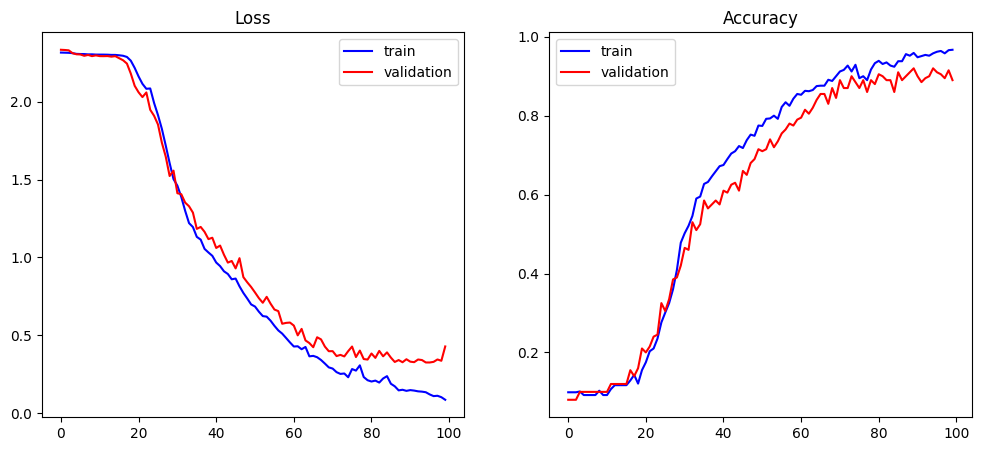

In [114]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Loss')
plt.plot(history['loss'], c='b', label='train')
plt.plot(history['val_loss'], c='r', label='validation')
plt.legend()
plt.subplot(122)
plt.title('Accuracy')
plt.plot(history['acc'], c='b', label='train')
plt.plot(history['val_acc'], c='r', label='validation')
plt.legend()

In [115]:
pred_dic = {'prob': [], 'pred': []}
with torch.no_grad():
    for img, lab in test_loader:
        x = img.to(device)
        pred = model.forward(x)
        for i in range(len(x)):
            probs = pred[i].cpu().detach().numpy()
            # probs -= np.min(probs)
            # probs /= np.sum(probs)
            pred_dic['prob'].append(probs)
            pred_dic['pred'].append(pred[i].argmax().item())
print(pred_dic['pred'][0])
print(pred_dic['prob'][0])
print(len(pred_dic['pred']))

7
[-28.58037   -6.516257 -17.070799  -5.576056 -16.798893   2.894517
 -51.437454  20.068287  -6.644189   4.172687]
200


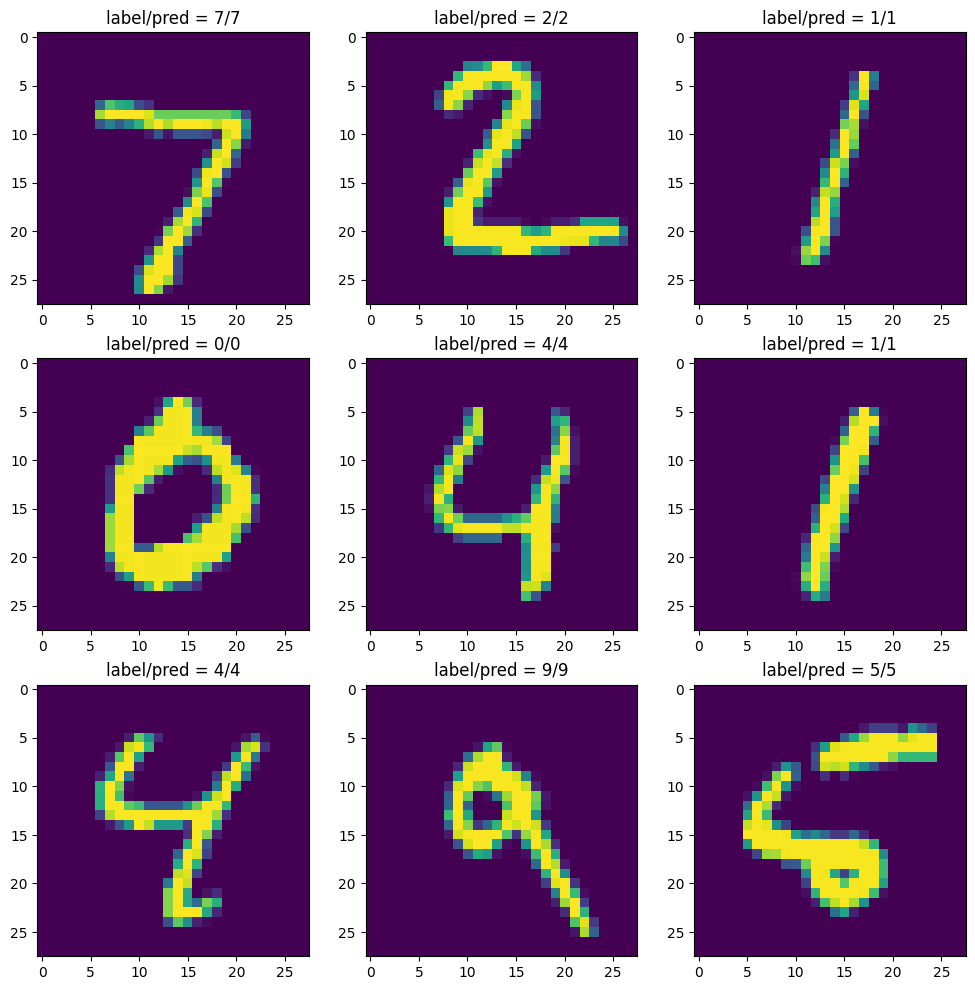

In [116]:
plt.figure(figsize=(12,12))
for i in range(9):
    img = np.moveaxis(mnist_test[i][0].detach().numpy(), 0 , -1)
    pred = pred_dic['pred'][i]
    # score = pred_dic['prob'][i][pred]
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(f'label/pred = {mnist_test[i][1]}/{pred}')

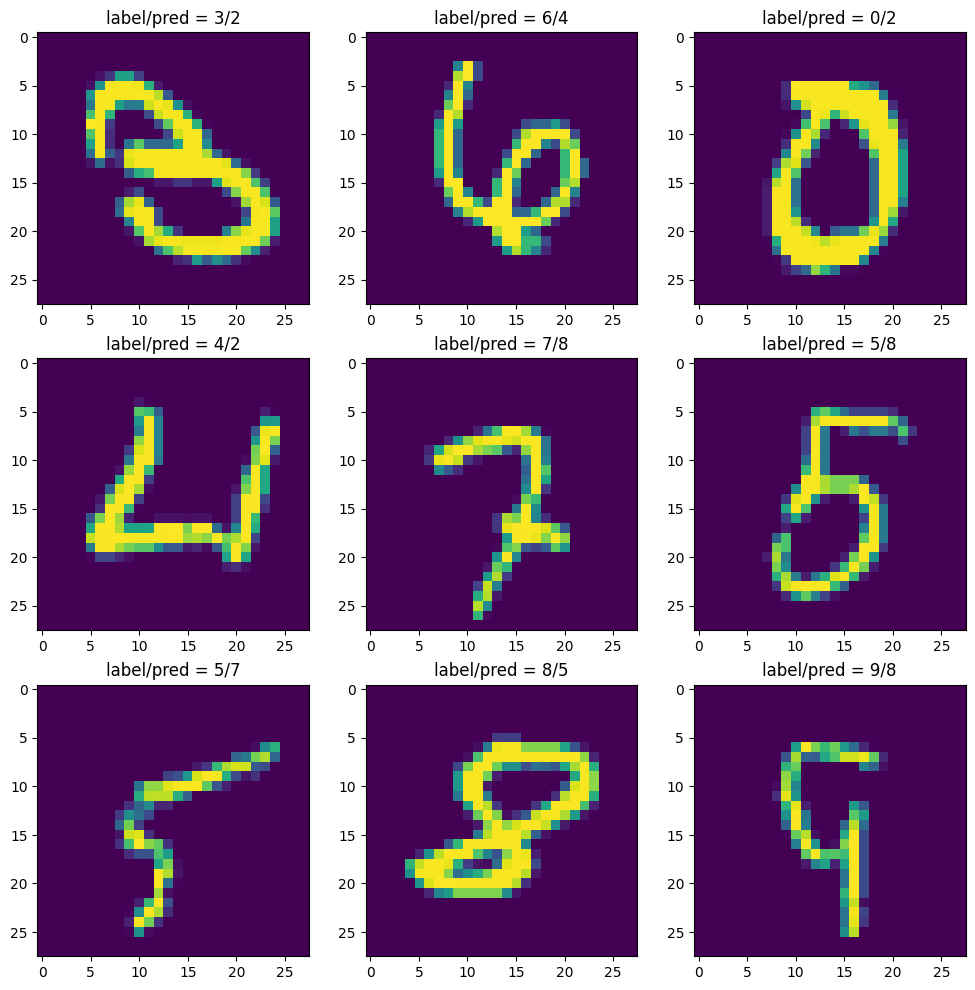

In [117]:
# false case
plt.figure(figsize=(12,12))
n = 0
for i in range(len(pred_dic['pred'])):
    pred = pred_dic['pred'][i]
    lab = mnist_test[i][1]
    if pred != lab and n < 9:
        n += 1
        img = np.moveaxis(mnist_test[i][0].detach().numpy(), 0 , -1)
        plt.subplot(3,3,n)
        plt.imshow(img)
        plt.title(f'label/pred = {mnist_test[i][1]}/{pred}')